In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import numpy as np
import pandas as pd
from pathlib import Path
import plotly.express as px
from functools import wraps
from entsoe import EntsoePandasClient

In [ ]:
from iaomai.outages import (
    preprocess_outages_data,
    aggregate_outages,
)
from iaomai.miscellaneous import simple_cache_csv_dataframe_fetch

In [4]:
ENTSOE_TOKEN = "34b5fee5-1333-4e97-9fdc-d713ae6ae9c1"
client = EntsoePandasClient(api_key=ENTSOE_TOKEN)
start = pd.Timestamp('20160101', tz='CET')
end = pd.Timestamp('20310101', tz='CET')

In [5]:
DATA_PATH = Path("../data/unavailability")
DUMP_DATA_PATH = Path("../dump_graphs")
DUMP_CSV_DATA_PATH = Path("../data/dump")
DATA_PATH_INSTALLED_GENERATION = Path("../data/static/installed_generation")

In [6]:
dict_data = {}

for country in ["CH", "FR"]:
    target_file = (
        DATA_PATH
        / f"unavailability_{country.lower()}_{start.strftime('%Y%m%d')}_{end.strftime('%Y%m%d')}.csv"
    )
    dict_data[country] = simple_cache_csv_dataframe_fetch(target_file)(
        client.query_unavailability_of_generation_units
    )(
        country,
        start=start,
        end=end,
        docstatus=None,
        periodstartupdate=None,
        periodendupdate=None,
    )


In [7]:
MIN_OUTAGE_DURATION = pd.Timedelta(days=1)

filtered_data_fr = preprocess_outages_data(
    raw_data=dict_data["FR"], outage_duration=MIN_OUTAGE_DURATION
)
filtered_data_ch = preprocess_outages_data(
    raw_data=dict_data["CH"], outage_duration=MIN_OUTAGE_DURATION
)
total_outages_fr = aggregate_outages(filtered_data=filtered_data_fr, by="total")
total_outages_ch = aggregate_outages(filtered_data=filtered_data_ch, by="total")
outages_per_unit_ch = aggregate_outages(
    filtered_data=filtered_data_ch, by="production_unit"
)
outages_per_unit_fr = aggregate_outages(
    filtered_data=filtered_data_fr, by="production_unit"
)
outages_per_type_fr = aggregate_outages(
    filtered_data=filtered_data_fr, by="businesstype"
)
outages_per_type_ch = aggregate_outages(
    filtered_data=filtered_data_ch, by="businesstype"
)

In [46]:
pd.set_option('display.max_rows', 160)
pd.set_option('display.max_columns', 160)

In [10]:
def plot_french_nuclear_outages(
    outages_data: pd.DataFrame, area: bool, font_size: int = 14, comment: str = ""
) -> pd.DataFrame:
    FESSENHEIM_1_SHUT_DOWN = pd.Timestamp("2020-02-22")
    FESSENHEIM_2_SHUT_DOWN = pd.Timestamp("2020-06-30")
    FLAMANVILLE_CONNECTION = pd.Timestamp("2024-12-21 11:48", tz="CET")
    SCHWEISSNAEHTE_PROBLEME_LETZTE_GENERATION_START = pd.Timestamp(
        "2021-11-01", tz="CET"
    )
    SCHWEISSNAEHTE_PROBLEME_LETZTE_GENERATION_END = pd.Timestamp("2023-12-01", tz="CET")
    if area:
        fig = px.area(outages_data, line_shape="hv")
    else:
        fig = px.line(outages_data, line_shape="hv")
    fig.add_vline(
        x=FESSENHEIM_2_SHUT_DOWN.timestamp()
        * 1000,  # required because of plotly bug, see https://github.com/plotly/plotly.py/issues/3065
        line_width=3,
        line_dash="dash",
        line_color="firebrick",
        annotation_text="Endgültige Abschaltung von Fessenheim 2",
        annotation_position="top left",
        annotation_font_size=font_size,
        annotation_font_color="firebrick",
        annotation_textangle=-90,
    )
    fig.add_vline(
        x=FESSENHEIM_1_SHUT_DOWN.timestamp() * 1000,
        line_width=3,
        line_dash="dash",
        line_color="firebrick",
        annotation_text="Endgültige Abschaltung von Fessenheim 1",
        annotation_position="top left",
        annotation_font_size=font_size,
        annotation_font_color="firebrick",
        annotation_textangle=-90,
    )
    fig.add_vline(
        x=FLAMANVILLE_CONNECTION.timestamp() * 1000,
        line_width=3,
        line_dash="dash",
        line_color="firebrick",
        annotation_text="Vernetzung von Flamanville 3",
        annotation_position="top right",
        annotation_font_size=font_size,
        annotation_font_color="firebrick",
        annotation_textangle=-90,
    )

    fig.add_vrect(
        x0=SCHWEISSNAEHTE_PROBLEME_LETZTE_GENERATION_START,
        x1=SCHWEISSNAEHTE_PROBLEME_LETZTE_GENERATION_END,
        annotation_text="Rissbefunde an <br> Schweissnähten <br> in den AKWs letzter Generation <br> (N3 + N4)",
        annotation_position="top left",
        fillcolor="goldenrod",
        annotation_font_size=font_size,
        opacity=0.3,
        line_width=1,
    )
    fig.update_layout(
        height=500,
        width=2000,
        font=dict(size=font_size),
        xaxis_title="Date",
        yaxis_title=f"MW in maintenance <br>{comment}",
    )
    return fig


def plot_swiss_nuclear_outages(
    outages_data: pd.DataFrame, area: bool, font_size: int = 14, comment: str = ""
) -> pd.DataFrame:
    if area:
        fig = px.area(outages_data, line_shape="hv")
    else:
        fig = px.line(outages_data, line_shape="hv")
    MUEHLEBERG_SHUT_DOWN = pd.Timestamp("2019-12-20")
    fig.add_vline(
        x=MUEHLEBERG_SHUT_DOWN.timestamp() * 1000,
        line_width=3,
        line_dash="dash",
        line_color="firebrick",
        annotation_text="Endgültige Abschaltung von Mühleberg",
        annotation_position="top right",
        annotation_font_size=font_size,
        annotation_font_color="firebrick",
        annotation_textangle=-90,
    )
    fig.update_layout(
        height=500,
        width=2000,
        font=dict(size=font_size),
        xaxis_title="Date",
        yaxis_title=f"MW in maintenance <br>{comment}",
    )
    return fig


In [11]:
fig_nuclear_outages_france_with_outage_type = plot_french_nuclear_outages(
    outages_data=outages_per_type_fr.loc[start:end, outages_per_type_fr.columns[::-1]],
    area=True,
    comment=f"Minimum outage duration: {MIN_OUTAGE_DURATION}",
)
fig_nuclear_outages_france_with_outage_type.show()

In [12]:
fig_nuclear_outages_france = plot_french_nuclear_outages(
    outages_data=pd.concat(
        [
            #french_installed_nuclear_capacity.rename("Installed nuclear capacity [MW]"),
            total_outages_fr.rename("Aggregated nuclear reactor outages [MW]"),
        ],
        axis=1,
    ).loc[start:end],
    area=False,
    comment=f"Minimum outage duration: {MIN_OUTAGE_DURATION}",
)
fig_nuclear_outages_france.update_traces(connectgaps=True)
fig_nuclear_outages_france.show()

In [13]:
fig_nuclear_outages_switzerland = plot_swiss_nuclear_outages(
    outages_data=pd.concat(
        [
            outages_per_unit_ch,
        ],
        axis=1,
    ).loc[start:end],
    area=True,
    comment=f"Minimum outage duration: {MIN_OUTAGE_DURATION}",
)
fig_nuclear_outages_switzerland.update_traces(connectgaps=True)
fig_nuclear_outages_switzerland.show()


<Axes: xlabel='week'>

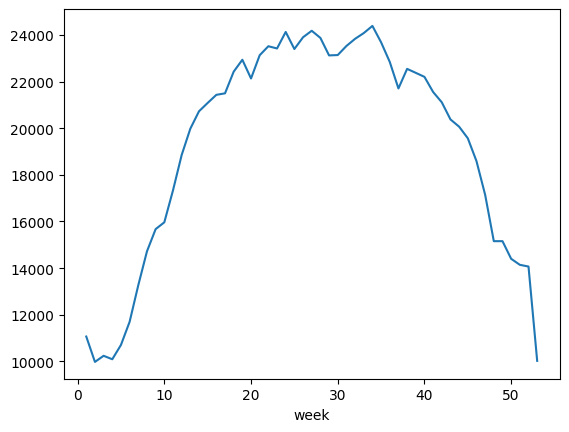

In [15]:
slice_past_recent_data = total_outages_fr[(total_outages_fr.index.year>2015) & (total_outages_fr.index.year<2026)].resample("D").mean().ffill()
slice_past_recent_data.groupby([slice_past_recent_data.index.isocalendar().week]).mean().plot()

In [16]:
# plot_swiss_nuclear_outages(
#     outages_data=outages_per_type_ch.loc[:, start:end].T,
#     area=True,
#     comment=f"Minimum outage duration: {MIN_OUTAGE_DURATION}",
# ).show()

In [17]:
# outages_per_type_ch.to_csv(DUMP_CSV_DATA_PATH / "outages_per_type_ch.csv")
# outages_per_type_fr.to_csv(DUMP_CSV_DATA_PATH / "outages_per_type_fr.csv")